# Modelagem M5 forecasting

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Bibliotecas

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import optuna
from lightgbm import early_stopping
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

### Data

In [7]:
# Caminho correto para a pasta dados_colab
df = pd.read_csv('/content/drive/MyDrive/dados_colab/final_df.csv', parse_dates=['date'])

# Verificar o carregamento
print("Formato do DataFrame:", df.shape)
print("Colunas disponíveis:", df.columns.tolist())

Formato do DataFrame: (58449330, 23)
Colunas disponíveis: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date', 'weekday', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'event_name', 'event_type', 'is_event', 'sell_price', 'day', 'week', 'quarter']


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58449330 entries, 0 to 58449329
Data columns (total 23 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item_id     object        
 2   dept_id     object        
 3   cat_id      object        
 4   store_id    object        
 5   state_id    object        
 6   d           object        
 7   sales       int64         
 8   date        datetime64[ns]
 9   weekday     object        
 10  wday        int64         
 11  month       int64         
 12  year        int64         
 13  snap_CA     int64         
 14  snap_TX     int64         
 15  snap_WI     int64         
 16  event_name  object        
 17  event_type  object        
 18  is_event    int64         
 19  sell_price  float64       
 20  day         int64         
 21  week        int64         
 22  quarter     int64         
dtypes: datetime64[ns](1), float64(1), int64(11), object(10)
memory usage: 10.0+ GB


In [9]:
# Verificar valores nulos
print("\nValores ausentes por coluna:")
print(df.isnull().sum())


Valores ausentes por coluna:
id                   0
item_id              0
dept_id              0
cat_id               0
store_id             0
state_id             0
d                    0
sales                0
date                 0
weekday              0
wday                 0
month                0
year                 0
snap_CA              0
snap_TX              0
snap_WI              0
event_name    53631910
event_type    53631910
is_event             0
sell_price           0
day                  0
week                 0
quarter              0
dtype: int64


## Feature Engineering

### Criação da variável de promoção ativa (snap_active)

#### Variáveis de promoção (snap_CA, snap_TX, snap_WI):

#### Essas colunas indicam se houve benefício do programa SNAP em cada estado, em determinado dia.
#### Decidi criar uma nova variável única snap_active, baseada no estado, que indica se houve SNAP ativo no dia para aquele estado.

In [10]:
# SNAP ativo dependendo do estado
df['snap_active'] = df.apply(
    lambda row: row['snap_CA'] if row['state_id'] == 'CA'
    else row['snap_TX'] if row['state_id'] == 'TX'
    else row['snap_WI'],
    axis=1
)

# Remover colunas SNAP individuais por estado
df.drop(columns=['snap_CA', 'snap_TX', 'snap_WI'], inplace=True)

### Criação de variáveis de séries temporais

#### Variáveis lag: O valor da venda de 7 dias atrás e 28 dias atrás entra como nova feature.
#### Variáveis rolling: Calcula a média móvel e o desvio padrão das vendas nos 7 dias anteriores e 28 dias anteriores.

In [11]:
# Ordenar o DataFrame por produto e data
df.sort_values(by=['id', 'date'], inplace=True)

# Lags de vendas (última semana e último mês)
df['lag_7'] = df.groupby('id')['sales'].shift(7)
df['lag_28'] = df.groupby('id')['sales'].shift(28)

# Médias móveis de vendas (com desvio padrão)
df['rolling_mean_7'] = df.groupby('id')['sales'].shift(1).rolling(window=7).mean()
df['rolling_std_7']  = df.groupby('id')['sales'].shift(1).rolling(window=7).std()

df['rolling_mean_28'] = df.groupby('id')['sales'].shift(1).rolling(window=28).mean()
df['rolling_std_28']  = df.groupby('id')['sales'].shift(1).rolling(window=28).std()

## Tratar NAs

In [12]:
# Verificar valores nulos
print("\nValores ausentes por coluna:")
print(df.isnull().sum())


Valores ausentes por coluna:
id                        0
item_id                   0
dept_id                   0
cat_id                    0
store_id                  0
state_id                  0
d                         0
sales                     0
date                      0
weekday                   0
wday                      0
month                     0
year                      0
event_name         53631910
event_type         53631910
is_event                  0
sell_price                0
day                       0
week                      0
quarter                   0
snap_active               0
lag_7                213430
lag_28               853720
rolling_mean_7       213430
rolling_std_7        213430
rolling_mean_28      853720
rolling_std_28       853720
dtype: int64


In [13]:
# Definir a condição: linhas onde 'is_event' é 0
condicao = df['is_event'] == 0

# Definir as colunas que você quer modificar
colunas_para_imputar = ['event_name', 'event_type']

# Usar .loc para selecionar as linhas e colunas específicas e preencher os NAs
df.loc[condicao, colunas_para_imputar] = df.loc[condicao, colunas_para_imputar].fillna('None')

In [14]:
# Lista das colunas com valores ausentes
cols_na = ['lag_7', 'lag_28', 'rolling_mean_7', 'rolling_std_7',
           'rolling_mean_28', 'rolling_std_28']

# Imputar com a mediana por produto
for col in cols_na:
    df[col] = df.groupby('id')[col].transform(lambda x: x.fillna(x.median()))

In [15]:
# Verificar valores nulos
print("\nValores ausentes por coluna:")
print(df.isnull().sum())


Valores ausentes por coluna:
id                 0
item_id            0
dept_id            0
cat_id             0
store_id           0
state_id           0
d                  0
sales              0
date               0
weekday            0
wday               0
month              0
year               0
event_name         0
event_type         0
is_event           0
sell_price         0
day                0
week               0
quarter            0
snap_active        0
lag_7              0
lag_28             0
rolling_mean_7     0
rolling_std_7      0
rolling_mean_28    0
rolling_std_28     0
dtype: int64


## Codificar variáveis categóricas com LabelEncoder

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58449330 entries, 0 to 58449329
Data columns (total 27 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               object        
 1   item_id          object        
 2   dept_id          object        
 3   cat_id           object        
 4   store_id         object        
 5   state_id         object        
 6   d                object        
 7   sales            int64         
 8   date             datetime64[ns]
 9   weekday          object        
 10  wday             int64         
 11  month            int64         
 12  year             int64         
 13  event_name       object        
 14  event_type       object        
 15  is_event         int64         
 16  sell_price       float64       
 17  day              int64         
 18  week             int64         
 19  quarter          int64         
 20  snap_active      int64         
 21  lag_7            float64     

In [17]:
# Colunas categóricas tipo 'object' para codificar
categorical_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
                    'weekday', 'event_name', 'event_type', 'd']

# Aplicar LabelEncoder em todas as colunas listadas
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

## Separação entre Treino/Teste
#### em séries temporais não utilizamos 70/30 ou 80/20

In [18]:
# Definir as features e target
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','sell_price', 'event_name', 'event_type', 'snap_active', 'day', 'month',
            'year', 'quarter', 'wday', 'is_event','lag_7', 'lag_28', 'rolling_mean_7', 'rolling_std_7','rolling_mean_28', 'rolling_std_28']
target = 'sales'

X = df[features]
y = df[target]

# Criar o validador
tscv = TimeSeriesSplit(n_splits=3)

# Listas para armazenar os folds
folds = []

# Separar os dados e armazenar em cada fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    folds.append({
        'fold': fold + 1,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    })

    print(f"Fold {fold+1} salvo: Train {train_idx[0]} → {train_idx[-1]} | Test {test_idx[0]} → {test_idx[-1]}")# Definir as features e target
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','sell_price', 'event_name', 'event_type', 'snap_active', 'day', 'month',
            'year', 'quarter', 'wday', 'is_event','lag_7', 'lag_28', 'rolling_mean_7', 'rolling_std_7','rolling_mean_28', 'rolling_std_28']
target = 'sales'

X = df[features]
y = df[target]

# Criar o validador
tscv = TimeSeriesSplit(n_splits=3)

# Listas para armazenar os folds
folds = []

# Separar os dados e armazenar em cada fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    folds.append({
        'fold': fold + 1,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    })

    print(f"Fold {fold+1} salvo: Train {train_idx[0]} → {train_idx[-1]} | Test {test_idx[0]} → {test_idx[-1]}")

Fold 1 salvo: Train 0 → 14612333 | Test 14612334 → 29224665
Fold 2 salvo: Train 0 → 29224665 | Test 29224666 → 43836997
Fold 3 salvo: Train 0 → 43836997 | Test 43836998 → 58449329
Fold 1 salvo: Train 0 → 14612333 | Test 14612334 → 29224665
Fold 2 salvo: Train 0 → 29224665 | Test 29224666 → 43836997
Fold 3 salvo: Train 0 → 43836997 | Test 43836998 → 58449329


### **Como o `TimeSeriesSplit` funciona**

O `TimeSeriesSplit` não embaralha os dados — ele respeita a ordem temporal.
Ou seja, ele vai dividindo assim:

| Fold | Treino (início → fim) | Teste (início → fim)    |
| ---- | --------------------- | ----------------------- |
| 1    | 0 → 14 612 333        | 14 612 334 → 29 224 665 |
| 2    | 0 → 29 224 665        | 29 224 666 → 43 836 997 |
| 3    | 0 → 43 836 997        | 43 836 998 → 58 449 329 |


* Cada fold **usa mais dados históricos** do que o anterior.
* O modelo sempre **treina no passado** e **testa no futuro** — o que simula bem o cenário real de previsão.
* Só que… o primeiro fold tem **menos histórico** e, portanto, **menos contexto** para aprender.

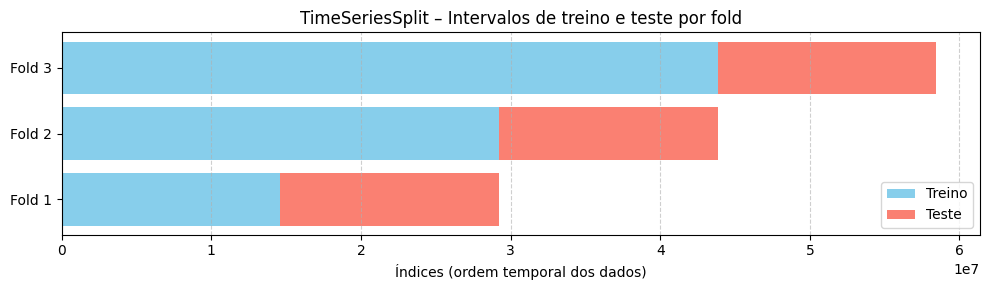

In [19]:
# --- DADOS DOS FOLDS ---
folds_info = [
    {"fold": 1, "train_start": 0, "train_end": 14612333, "test_start": 14612334, "test_end": 29224665},
    {"fold": 2, "train_start": 0, "train_end": 29224665, "test_start": 29224666, "test_end": 43836997},
    {"fold": 3, "train_start": 0, "train_end": 43836997, "test_start": 43836998, "test_end": 58449329},
]

# --- PLOT ---
plt.figure(figsize=(10, 3))

for fold in folds_info:
    # Treino
    plt.barh(f"Fold {fold['fold']}", fold["train_end"] - fold["train_start"],
             left=fold["train_start"], color="skyblue",
             label="Treino" if fold["fold"] == 1 else "")
    # Teste
    plt.barh(f"Fold {fold['fold']}", fold["test_end"] - fold["test_start"],
             left=fold["test_start"], color="salmon",
             label="Teste" if fold["fold"] == 1 else "")

plt.xlabel("Índices (ordem temporal dos dados)")
plt.title("TimeSeriesSplit – Intervalos de treino e teste por fold")
plt.legend()
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Modelos

### Linear Regression

In [20]:
lr_models = []

for fold in folds:
    model = LinearRegression()
    model.fit(fold['X_train'], fold['y_train'])

    y_pred = model.predict(fold['X_test'])
    rmse = np.sqrt(mean_squared_error(fold['y_test'], y_pred))

    lr_models.append(model)
    print(f"[Linear Regression] Fold {fold['fold']} – RMSE: {rmse:.4f}")

[Linear Regression] Fold 1 – RMSE: 3.0052
[Linear Regression] Fold 2 – RMSE: 1.5783
[Linear Regression] Fold 3 – RMSE: 1.2901


### LightGBM

In [21]:
lgb_models = []

for fold in folds:
    train_data = lgb.Dataset(fold['X_train'], label=fold['y_train'])
    valid_data = lgb.Dataset(fold['X_test'], label=fold['y_test'])

    params = {
        'device': 'gpu',            # Ativa GPU
        'gpu_use_dp': False,        # Usa float32 (menos RAM)
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'verbosity': -1
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=100,
        callbacks=[early_stopping(stopping_rounds=10), lgb.log_evaluation()]
    )

    y_pred = model.predict(fold['X_test'])
    rmse = np.sqrt(mean_squared_error(fold['y_test'], y_pred))

    lgb_models.append(model) # Appending models inside loop might consume too much memory
    print(f"[LightGBM GPU] Fold {fold['fold']} – RMSE: {rmse:.4f}")

[1]	valid_0's rmse: 5.25674
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 4.91402
[3]	valid_0's rmse: 4.60839
[4]	valid_0's rmse: 4.34641
[5]	valid_0's rmse: 4.12268
[6]	valid_0's rmse: 3.92909
[7]	valid_0's rmse: 3.76905
[8]	valid_0's rmse: 3.63343
[9]	valid_0's rmse: 3.51844
[10]	valid_0's rmse: 3.4205
[11]	valid_0's rmse: 3.33903
[12]	valid_0's rmse: 3.2668
[13]	valid_0's rmse: 3.21113
[14]	valid_0's rmse: 3.16367
[15]	valid_0's rmse: 3.12589
[16]	valid_0's rmse: 3.09154
[17]	valid_0's rmse: 3.06237
[18]	valid_0's rmse: 3.039
[19]	valid_0's rmse: 3.02104
[20]	valid_0's rmse: 3.00523
[21]	valid_0's rmse: 2.9905
[22]	valid_0's rmse: 2.97892
[23]	valid_0's rmse: 2.97067
[24]	valid_0's rmse: 2.96406
[25]	valid_0's rmse: 2.95671
[26]	valid_0's rmse: 2.95418
[27]	valid_0's rmse: 2.95039
[28]	valid_0's rmse: 2.94499
[29]	valid_0's rmse: 2.94059
[30]	valid_0's rmse: 2.93886
[31]	valid_0's rmse: 2.93709
[32]	valid_0's rmse: 2.93477
[33]	valid_0's rmse: 2.93

### XGBoost

In [22]:
xgb_models = []

for fold in folds:
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        objective='reg:squarederror',
        device='cuda',          # ⚡ Ativa GPU (modo moderno)
        tree_method='hist',
        random_state=42
    )

    model.fit(
        fold['X_train'],
        fold['y_train'],
        eval_set=[(fold['X_test'], fold['y_test'])]
    )

    y_pred = model.predict(fold['X_test'])
    rmse = np.sqrt(mean_squared_error(fold['y_test'], y_pred))

    xgb_models.append(model)
    print(f"[XGBoost GPU] Fold {fold['fold']} - RMSE: {rmse:.4f}")

[0]	validation_0-rmse:5.25246
[1]	validation_0-rmse:4.91697
[2]	validation_0-rmse:4.64185
[3]	validation_0-rmse:4.37776
[4]	validation_0-rmse:4.17436
[5]	validation_0-rmse:4.01163
[6]	validation_0-rmse:3.87073
[7]	validation_0-rmse:3.73218
[8]	validation_0-rmse:3.64345
[9]	validation_0-rmse:3.57172
[10]	validation_0-rmse:3.51332
[11]	validation_0-rmse:3.46082
[12]	validation_0-rmse:3.42371
[13]	validation_0-rmse:3.39809
[14]	validation_0-rmse:3.39407
[15]	validation_0-rmse:3.37953
[16]	validation_0-rmse:3.37493
[17]	validation_0-rmse:3.37012
[18]	validation_0-rmse:3.36715
[19]	validation_0-rmse:3.36487
[20]	validation_0-rmse:3.36583
[21]	validation_0-rmse:3.36841
[22]	validation_0-rmse:3.36904
[23]	validation_0-rmse:3.36913
[24]	validation_0-rmse:3.37394
[25]	validation_0-rmse:3.38279
[26]	validation_0-rmse:3.38434
[27]	validation_0-rmse:3.39117
[28]	validation_0-rmse:3.38702
[29]	validation_0-rmse:3.38458
[30]	validation_0-rmse:3.38900
[31]	validation_0-rmse:3.39020
[32]	validation_0-

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [19:25:47] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[XGBoost GPU] Fold 1 - RMSE: 3.4122
[0]	validation_0-rmse:2.18524
[1]	validation_0-rmse:2.07868
[2]	validation_0-rmse:1.98862
[3]	validation_0-rmse:1.91265
[4]	validation_0-rmse:1.84869
[5]	validation_0-rmse:1.79596
[6]	validation_0-rmse:1.75254
[7]	validation_0-rmse:1.71610
[8]	validation_0-rmse:1.68595
[9]	validation_0-rmse:1.66073
[10]	validation_0-rmse:1.64052
[11]	validation_0-rmse:1.62395
[12]	validation_0-rmse:1.60992
[13]	validation_0-rmse:1.59864
[14]	validation_0-rmse:1.58923
[15]	validation_0-rmse:1.58182
[16]	validation_0-rmse:1.57542
[17]	validation_0-rmse:1.57065
[18]	validation_0-rmse:1.56692
[19]	validation_0-rmse:1.56372
[20]	validation_0-rmse:1.56143
[21]	validation_0-rmse:1.55920
[22]	validation_0-rmse:1.55763
[23]	validation_0-rmse:1.55596
[24]	validation_0-rmse:1.55487
[25]	validation_0-rmse:1.55362
[26]	validation_0-rmse:1.55279
[27]	validation_0-rmse:1.55221
[28]	validation_0-rmse:1.55174
[29]	validation_0-rmse:1.55131
[30]	validation_0-rmse:1.55089
[31]	validati

### Comparação dos RMSE

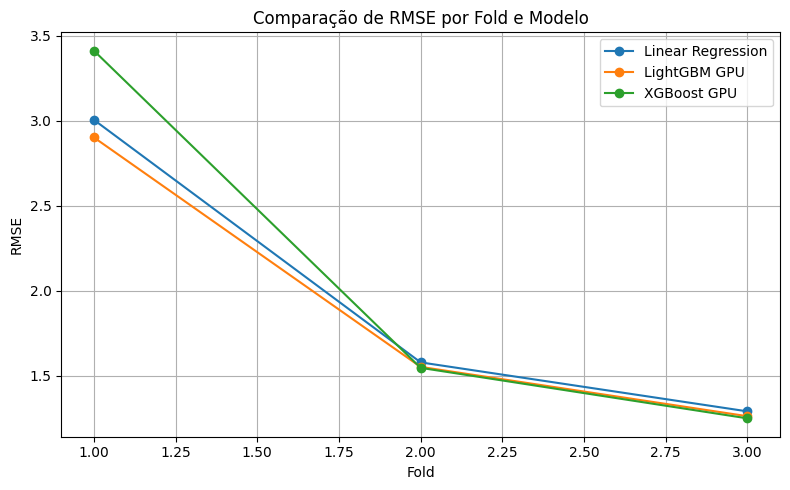

In [23]:
# Dados dos RMSEs obtidos
data = {
    'Modelo': ['Linear Regression', 'Linear Regression', 'Linear Regression',
               'LightGBM GPU', 'LightGBM GPU', 'LightGBM GPU',
               'XGBoost GPU', 'XGBoost GPU', 'XGBoost GPU'],
    'Fold': [1, 2, 3, 1, 2, 3, 1, 2, 3],
    'RMSE': [3.0052, 1.5783, 1.2901,
             2.9017, 1.5518, 1.2616,
             3.4122, 1.5461, 1.2490]
}

# Cria o DataFrame
df = pd.DataFrame(data)

# Gráfico de linhas comparando RMSEs por fold
plt.figure(figsize=(8, 5))
for model in df['Modelo'].unique():
    subset = df[df['Modelo'] == model]
    plt.plot(subset['Fold'], subset['RMSE'], marker='o', label=model)

plt.title('Comparação de RMSE por Fold e Modelo')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Resumo de desempenho por modelo:

              Modelo     Média  Desvio Padrão
0  Linear Regression  1.957867       0.918393
1       LightGBM GPU  1.905033       0.875250
2        XGBoost GPU  2.069100       1.172606


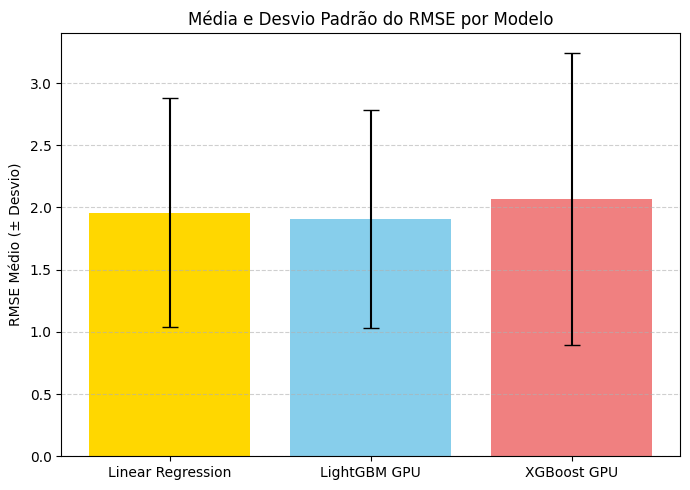

In [24]:
# RMSEs por modelo e fold (valores que você mediu)
data = {
    'Modelo': ['Linear Regression', 'LightGBM GPU', 'XGBoost GPU'],
    'Fold 1': [3.0052, 2.9017, 3.4122],
    'Fold 2': [1.5783, 1.5518, 1.5461],
    'Fold 3': [1.2901, 1.2616, 1.2490]
}

df = pd.DataFrame(data)

# Calcular média e desvio padrão
df['Média'] = df[['Fold 1', 'Fold 2', 'Fold 3']].mean(axis=1)
df['Desvio Padrão'] = df[['Fold 1', 'Fold 2', 'Fold 3']].std(axis=1)

print("Resumo de desempenho por modelo:\n")
print(df[['Modelo', 'Média', 'Desvio Padrão']])

# Gráfico de médias com desvio padrão
plt.figure(figsize=(7,5))
plt.bar(df['Modelo'], df['Média'], yerr=df['Desvio Padrão'], capsize=6, color=['gold', 'skyblue', 'lightcoral'])
plt.title('Média e Desvio Padrão do RMSE por Modelo')
plt.ylabel('RMSE Médio (± Desvio)')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Por que o Fold 1 tá com RMSE mais alto?

##### Como o treino do Fold 1 usa os primeiros dados (0 → 14612333) e o teste vem logo depois, ele tá prevendo um período futuro usando apenas o início da série.
##### Já nos folds seguintes, o modelo treina com mais dados e períodos mais recentes — então ele aprende melhor o comportamento mais atual, o que explica o RMSE bem menor nos folds 2 e 3.

## O **LightGBM GPU** teve o **menor RMSE médio**, ou seja, foi o modelo mais preciso em geral.
* Ele também manteve um **desvio padrão menor** que o XGBoost — isso significa que o LightGBM foi **mais estável** entre os folds (menos sensível a mudanças no período).
* O **XGBoost GPU** teve desempenho parecido, mas um pouco mais volátil

## Tuning dos hiperparámetros usando `Optuna`

In [25]:
# Função de avaliação (objeto de otimização)
def objective(trial):

    # Hiperparâmetros que o Optuna vai testar
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "device_type": "gpu",     # Usa GPU
        "gpu_use_dp": False,      # float32 = mais rápido
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
    }

    rmses = []

    # Validação cruzada temporal (3 folds)
    for fold in folds:
        train_data = lgb.Dataset(fold['X_train'], label=fold['y_train'])
        valid_data = lgb.Dataset(fold['X_test'], label=fold['y_test'], reference=train_data)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[valid_data],
            num_boost_round=1000,
            callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
        )

        y_pred = model.predict(fold['X_test'])
        rmse = np.sqrt(mean_squared_error(fold['y_test'], y_pred))
        rmses.append(rmse)

    # Retorna a média dos RMSEs (quanto menor, melhor)
    return np.mean(rmses)

In [26]:
# Cria o estudo do Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

print("Melhor RMSE médio:", study.best_value)
print("Melhores parâmetros encontrados:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-10-24 19:26:42,995] A new study created in memory with name: no-name-7f2a33ec-f079-4178-90f6-5e1c39cb965c


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-10-24 19:51:52,097] Trial 0 finished with value: 1.8935230564897294 and parameters: {'learning_rate': 0.13090869299518415, 'num_leaves': 30, 'max_depth': 7, 'min_data_in_leaf': 165, 'feature_fraction': 0.825356496444401, 'bagging_fraction': 0.9729565596900845, 'bagging_freq': 5, 'lambda_l1': 7.741204224121754, 'lambda_l2': 5.784147465308881}. Best is trial 0 with value: 1.8935230564897294.
[I 2025-10-24 20:37:12,406] Trial 1 finished with value: 1.897152917061329 and parameters: {'learning_rate': 0.01851419288363873, 'num_leaves': 107, 'max_depth': 6, 'min_data_in_leaf': 93, 'feature_fraction': 0.6788818854137901, 'bagging_fraction': 0.7818645916834444, 'bagging_freq': 5, 'lambda_l1': 0.44267415373887453, 'lambda_l2': 3.595473673271142}. Best is trial 0 with value: 1.8935230564897294.
[I 2025-10-24 21:13:50,206] Trial 2 finished with value: 1.8906034135614354 and parameters: {'learning_rate': 0.027182062341501608, 'num_leaves': 114, 'max_depth': 15, 'min_data_in_leaf': 140, 'fe

## Salvar modelo

In [27]:
# Pega os melhores parâmetros do Optuna
best_params = study.best_params
best_params.update({
    "objective": "regression",
    "metric": "rmse",
    "device_type": "gpu",
    "verbosity": -1
})

# Cria o dataset completo (todo o X e y)
train_all = lgb.Dataset(X, label=y)

# Treina o modelo final
final_model = lgb.train(best_params, train_all, num_boost_round=1000)

In [29]:
path = '/content/drive/MyDrive/dados_colab/lightgbm_folds_tunado_gpu.joblib'

# Salva o modelo treinado
joblib.dump(final_model, path)

['/content/drive/MyDrive/dados_colab/lightgbm_folds_tunado_gpu.joblib']